# Nature Conservancy Fish Classification - Bounding Box Regressor

### Imports & environment

In [1]:
import os
import ujson as json
import PIL
import random

from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D, Activation, Input, Flatten
from keras.models import Sequential

from collections import defaultdict
from utils import * 
from vgg16bn import Vgg16BN
from glob import glob

ROOT_DIR = os.getcwd()
DATA_HOME_DIR = ROOT_DIR + '/data/'
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 980M (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5105)


### Config & Hyperparameters

In [35]:
# paths
data_path = DATA_HOME_DIR + '/nof_excl/' 
split_train_path = data_path + '/train/'
valid_path = data_path + '/valid/'
test_path = DATA_HOME_DIR + '/test/'

# data
batch_size = 8
nb_split_train_samples = 2944
nb_valid_samples = 395
nb_full_train_samples = nb_split_train_samples + nb_valid_samples
nb_test_samples = 1000
classes = ["ALB", "BET", "DOL", "LAG", "OTHER", "SHARK", "YFT"]
nb_classes = len(classes)

# model
nb_epoch = 50
lr = 1e-2

### Utils

In [3]:
def get_classes(trn_path, val_path, test_path):
    batches = get_batches(trn_path, shuffle=False, batch_size=1, target_size=(360, 640))
    val_batches = get_batches(val_path, shuffle=False, batch_size=1, target_size=(360, 640))
    test_batches = get_batches(test_path, shuffle=False, batch_size=1, target_size=(360, 640))
    return val_batches.filenames, batches.filenames, test_batches.filenames

In [4]:
val_filenames, filenames, test_filenames = get_classes(split_train_path, valid_path, test_path)

Found 2944 images belonging to 7 classes.
Found 395 images belonging to 7 classes.
Found 1000 images belonging to 1 classes.


In [5]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

### Building Model and Saving/Loading Precomputed Conv Features

In [6]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [7]:
# batches = get_batches(split_train_path, batch_size=1, target_size=(360, 640), shuffle=False,
#                       class_mode=None)
# conv_trn_feat = vgg640.predict_generator(batches, nb_split_train_samples)
# save_array(DATA_HOME_DIR + 'precomputed/trn_ft_640_nofxcl.dat', conv_trn_feat)

# del conv_trn_feat

In [8]:
# val_batches = get_batches(valid_path, batch_size=1, target_size=(360, 640), shuffle=False,
#                           class_mode=None)
# conv_val_feat = vgg640.predict_generator(val_batches, nb_valid_samples)
# save_array(DATA_HOME_DIR + 'precomputed/val_ft_640_nofxcl.dat', conv_val_feat)

# del conv_val_feat

In [9]:
# test_batches = get_batches(test_path, batch_size=1, target_size=(360, 640), shuffle=False,
#                            class_mode=None)
# conv_test_feat = vgg640.predict_generator(test_batches, nb_test_samples)
# save_array(DATA_HOME_DIR + 'precomputed/test_ft_640_nofxcl.dat', conv_test_feat)

# del conv_test_feat

In [10]:
conv_val_feat = load_array(DATA_HOME_DIR + 'precomputed/val_ft_640_nofxcl.dat')
conv_trn_feat = load_array(DATA_HOME_DIR + 'precomputed/trn_ft_640_nofxcl.dat')
# conv_test_feat = load_array(DATA_HOME_DIR + 'precomputed/test_ft_640_nofxcl.dat')

Sample images for visualizing model results (from validation set):

In [11]:
smp = get_data(valid_path, target_size=(360, 640))

Found 395 images belonging to 7 classes.


### Bounding Box Loading and Application

In [12]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [13]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('bb_annotations/{}.json'.format(c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
            

bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [14]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [15]:
class_dict = defaultdict(str)

for fp in glob(data_path + '*/*/*.jpg'):
    cls = fp.split('/')[-2]
    im = fp.split('/')[-1]
    class_dict[im] = cls
    
print("Image Records:", len(class_dict.keys()))

Image Records: 3339


In [16]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb):
    cropsize = 224
    size = bb["size"]
    bb = [bb[p] for p in bb_params]
    
    # conversion factors
    conv_x = (640. / size[0])
    conv_y = (360. / size[1])
    
    # make the size conversions
    width, height = size[0]*conv_x, size[1]*conv_y
    x = bb[2]*conv_x
    y = bb[3]*conv_y
    
    # offset/padding adjustments
    x = max(x - 10, 0)
    y = max(y - 10, 0)
    
    if x + cropsize > width:
        x = width - cropsize
    if y + cropsize > height:
        y = height - cropsize
    
    bb[0] = cropsize
    bb[1] = cropsize
    bb[2] = x
    bb[3] = y
    return bb

In [17]:
for c in classes:
    fns = glob(data_path + '*/*/*.jpg')
    
    for fn in fns:
        f_id = fn.split("/")[-1]
        im = PIL.Image.open(fn)
        width, height = im.size
    
        if not f_id in bb_json.keys():
            x = random.uniform(0, width)
            y = random.uniform(0, height)
            bb_json[f_id] = {"height": 0, "width": 0, "x": x, "y": y, "size": im.size}
        else:
            anno = bb_json[f_id]
            x, y = anno["x"], anno["y"]
            bb_json[f_id] = {"height": 0, "width": 0, "x": x, "y": y, "size": im.size}

In [18]:
trn_bbox = np.stack([convert_bb(bb_json[f]) for f in raw_filenames]).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f]) for f in raw_val_filenames]).astype(np.float32)

Visualize result:

In [19]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)


def show_bb(i):
    bb = val_bbox[i]
    plot(smp[i])
    plt.gca().add_patch(create_rect(bb))

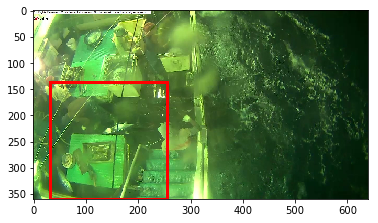

In [20]:
show_bb(25)

### Train the BB Regressor

In [21]:
conv_layers, _ = split_at(vgg640, Convolution2D)
input_shape = conv_layers[-1].output_shape[1:]

del vgg640; del conv_layers

In [34]:
model = Sequential()

model.add(AveragePooling2D(input_shape=input_shape))
model.add(BatchNormalization(axis=1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4))

model.compile(Adam(lr=lr, decay=0.001), loss='mse')

/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1505: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='average_exc_pad')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1505: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='average_exc_pad')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1505: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='average_exc_pad')


In [36]:
ckpt = ModelCheckpoint('models/bb_regressor/360x640/loss-{val_loss:.2f}_vgg16_bn.h5', monitor='val_loss',
                       verbose=0, save_best_only=True, save_weights_only=True)

model.fit(conv_trn_feat, trn_bbox,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          verbose=2,
          validation_data=(conv_val_feat, val_bbox),
          callbacks=[ckpt])

Train on 2944 samples, validate on 395 samples
Epoch 1/50
14s - loss: 7545.5941 - val_loss: 732.7828
Epoch 2/50
14s - loss: 1131.8147 - val_loss: 587.4558
Epoch 3/50
14s - loss: 961.5311 - val_loss: 552.3029
Epoch 4/50
14s - loss: 913.7735 - val_loss: 533.8593
Epoch 5/50
14s - loss: 834.9914 - val_loss: 463.9377
Epoch 6/50
14s - loss: 743.1846 - val_loss: 475.8544
Epoch 7/50
14s - loss: 807.4734 - val_loss: 448.8278
Epoch 8/50
14s - loss: 727.4317 - val_loss: 460.6738
Epoch 9/50
14s - loss: 735.2908 - val_loss: 440.9505
Epoch 10/50
14s - loss: 682.4200 - val_loss: 441.4024
Epoch 11/50
14s - loss: 754.9890 - val_loss: 449.3416
Epoch 12/50
14s - loss: 703.2435 - val_loss: 438.9061
Epoch 13/50
14s - loss: 683.9046 - val_loss: 432.4986
Epoch 14/50
14s - loss: 685.6273 - val_loss: 439.2730
Epoch 15/50
14s - loss: 719.1785 - val_loss: 430.8940
Epoch 16/50
14s - loss: 660.5070 - val_loss: 442.9309
Epoch 17/50
14s - loss: 613.6242 - val_loss: 429.9496
Epoch 18/50
14s - loss: 652.8911 - val_los

In [37]:
model.load_weights('models/bb_regressor/360x640/loss-408.47_vgg16_bn.h5')  # current best

In [38]:
pred = model.predict(conv_val_feat[0:15])

Visualize predictions on sample images:

In [39]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[i]
    plt.figure(figsize=(6,6))
    plot(smp[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

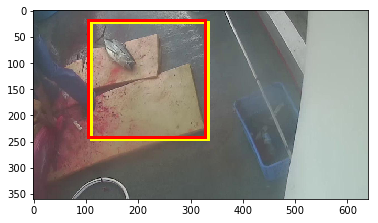

In [45]:
show_bb_pred(10)